# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
# Add your imports here
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
spark = SparkSession.builder.getOrCreate()
%matplotlib inline

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [3]:
# Load the data
posts_df = spark.read.json("data/Posts.json")

In [4]:
posts_df.show(2, truncate=False, vertical=True)
posts_df.printSchema()

-RECORD 0--------------------------------------------------------------------
 CreationDate | 2010-10-26T03:17:55.603+02:00                                
 Id           | 4020437                                                      
 ParentId     | null                                                         
 PostTypeId   | 1                                                            
 Score        | 0                                                            
 Tags         | <asp.net-mvc><jquery-ui>                                     
 Title        | display jquery dialog till data is loaded                    
 ViewCount    | 510                                                          
-RECORD 1--------------------------------------------------------------------
 CreationDate | 2010-10-26T03:18:17.873+02:00                                
 Id           | 4020438                                                      
 ParentId     | null                                            

In [5]:
# Convert the timestamp string to datetime object
posts_df = posts_df.withColumn('CreationDate',F.to_timestamp(posts_df.CreationDate, "yyy-MM-dd'T'HH:mm:ss.SSSXXX"))
posts_df.show(2, truncate=True, vertical=True)
posts_df.printSchema()

-RECORD 0----------------------------
 CreationDate | 2010-10-26 03:17:55  
 Id           | 4020437              
 ParentId     | null                 
 PostTypeId   | 1                    
 Score        | 0                    
 Tags         | <asp.net-mvc><jqu... 
 Title        | display jquery di... 
 ViewCount    | 510                  
-RECORD 1----------------------------
 CreationDate | 2010-10-26 03:18:17  
 Id           | 4020438              
 ParentId     | null                 
 PostTypeId   | 1                    
 Score        | 0                    
 Tags         | <javascript><html... 
 Title        | Why can only my m... 
 ViewCount    | 62                   
only showing top 2 rows

root
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long 

In [6]:
# Create a file for the questions only
# We take off null columns (ParentId being always null for questions)
questions_df = posts_df.filter(posts_df.PostTypeId==1)
questions_df = questions_df.drop("PostTypeId", "ParentId")
questions_df.write.parquet("data/questions.parquet")

In [7]:
# Create a file for the answers only
# We take off null columns (Tags, Title and ViewCount being always null for answers)
answers_df = posts_df.filter(posts_df.PostTypeId==2)
answers_df = answers_df.drop("PostTypeId", "Tags", "Title", "ViewCount")
answers_df.write.parquet("data/answers.parquet")

In [8]:
del posts_df
questions_df.persist()
answers_df.persist()

DataFrame[CreationDate: timestamp, Id: bigint, ParentId: bigint, Score: bigint]

#### 1. How many questions have been asked on StackOverflow?

In [9]:
print("%d questions have been asked on StackOverflow." % questions_df.count())

15647060 questions have been asked on StackOverflow.


#### 2. How many answers have been given?

In [10]:
print("%d responses have been given on StackOverflow." % answers_df.count())

25192772 responses have been given on StackOverflow.


#### 3. What is the percentage of questions with a score of 0?

In [11]:
num_score_null = questions_df.filter(questions_df.Score==0).count()
num_score_total = questions_df.count()
percentage = num_score_null/num_score_total * 100
print("The percentage of questions with a score of 0 is: %0.2f%%." % percentage)

The percentage of questions with a score of 0 is: 46.54%.


**Hint:** Load the dataset from the Parquet file for the next tasks.

In [12]:
questions_df = spark.read.load("data/questions.parquet")
answers_df = spark.read.load("data/answers.parquet")

# We create a lazily evaluated "view" to use Spark SQL
questions_df.createOrReplaceTempView("questions")
answers_df.createOrReplaceTempView("answers")

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

In [13]:
questions_df.select("Id","Tags").show(5, truncate=False)

+--------+-------------------------------------------------------------------------+
|Id      |Tags                                                                     |
+--------+-------------------------------------------------------------------------+
|45740348|<flash><react-native>                                                    |
|45740355|<postgresql><formatting><plpgsql>                                        |
|45740358|<python><websocket><python-asyncio>                                      |
|45740363|<facebook><facebook-javascript-sdk><share><facebook-opengraph><opengraph>|
|45740371|<mongodb><shell>                                                         |
+--------+-------------------------------------------------------------------------+
only showing top 5 rows



In [14]:
# We parse the tag column to get the information about each single tag
q_tags = questions_df.withColumn("Tag", F.explode(F.split(questions_df.Tags, "><"))).select("Id", "Tag")

# For the first "<" and the last ">"
q_tags = q_tags.withColumn("Tag", F.regexp_replace(q_tags.Tag, "<|>", ""))
q_tags.write.parquet("data/questions_tags.parquet")
q_tags.persist()
q_tags.show(10, truncate=False)

+--------+-----------------------+
|Id      |Tag                    |
+--------+-----------------------+
|45740348|flash                  |
|45740348|react-native           |
|45740355|postgresql             |
|45740355|formatting             |
|45740355|plpgsql                |
|45740358|python                 |
|45740358|websocket              |
|45740358|python-asyncio         |
|45740363|facebook               |
|45740363|facebook-javascript-sdk|
+--------+-----------------------+
only showing top 10 rows



In [15]:
q_tags = spark.read.load("data/questions_tags.parquet")

#### 1) What is the proportion of tags that appear in fewer than 100 questions?

In [16]:
# We create a lazily evaluated "view" to use Spark SQL
q_tags.createOrReplaceTempView("q_tags")

tags_count = spark.sql("SELECT Tag, COUNT(Id) AS Count FROM q_tags GROUP BY Tag")
rare_tags_count = tags_count.filter(tags_count.Count < 100).count()
total_tags_count = spark.sql("SELECT COUNT(DISTINCT Tag) AS TotalCount FROM q_tags").first().TotalCount

In [17]:
print("The proportion of tags that appear in fewer than 100 questions is: {:.2f}%"
      .format((rare_tags_count / total_tags_count)*100))

The proportion of tags that appear in fewer than 100 questions is: 67.98%


**Explanations**: This shows that more than two-thirds of all tags are rarely used. In other words, the same tags are often used.

#### 2) Plot the distribution of the tag counts using an appropriate representation.

In [18]:
tags_count_pd = tags_count.toPandas()
tags_count_pd.describe()

Count
count  5.299400e+04
mean   8.809450e+02
std    1.598885e+04
min    1.000000e+00
25%    1.000000e+01
50%    3.700000e+01
75%    1.570000e+02
max    1.585495e+06

In [19]:
def plot_loglog_hist(x, xlabel, ylabel, title, bins=100):
    hist, bins = np.histogram(x, bins=bins)
    cumhist = np.flip(np.cumsum(np.flip(hist, 0)), 0)
    f = plt.figure()
    f.suptitle(title)
    ax = plt.loglog(bins[1:], cumhist, marker=".")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel) 

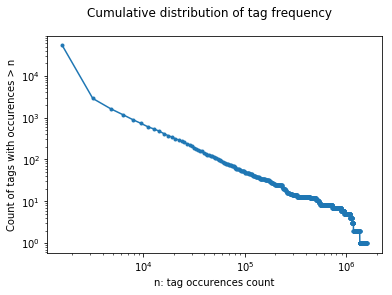

In [20]:
plot_loglog_hist(tags_count_pd.Count, 
                 "n: tag occurences count", 
                 "Count of tags with occurences > n",
                 "Cumulative distribution of tag frequency",                 
                 bins=1000)

**Explanations**: We can see that the cumulative distribution follows a straight line (at least for 3e3 < n < 4e5). The drop at the begining highlight the fact that the majority of tags are rarely used (< 2e4 times). Then we have an exponential decay in the count of tags occurence, that is a lot of tags that appear in a small number of questions and a small proportion of them are very frequently used. This confirms the conclusion we made in the previous question.

#### 3) Plot a bar chart with the number of questions for the 10 most popular tags.

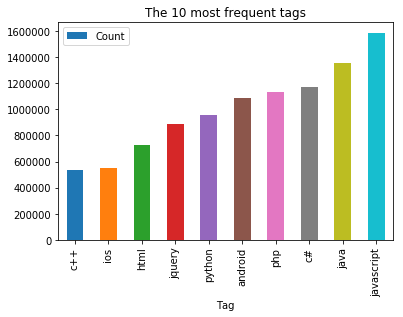

In [21]:
most_frequent_tags = tags_count_pd.sort_values("Count").tail(10)
_ = most_frequent_tags.plot.bar("Tag", "Count", title="The 10 most frequent tags")

**Explanations**: From the most used tag ("javascript") to the 8th most used one ("html"), the proportion is divided by two. This implies that there are strong outliers in the tag frequency: here we are only comparing the 10 most used tags regarding the 52'994 that exist. Even among the top-used tags, some are far more used than other.

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

#### 1. Get the view count and score of the questions with tag random-effects and visualize the relation between these two variables using an appropriate plot.

In [22]:
query="""
SELECT ViewCount, Score
FROM questions q INNER JOIN q_tags t
WHERE q.Id=t.Id AND t.Tag='random-effects'
SORT BY ViewCount
"""
view_score = spark.sql(query).toPandas()

In [23]:
view_score.describe()

ViewCount       Score
count    100.000000  100.000000
mean    1191.830000    1.500000
std     5037.166977    4.154832
min       10.000000   -2.000000
25%       64.250000    0.000000
50%      179.000000    0.000000
75%      534.000000    1.000000
max    42678.000000   31.000000

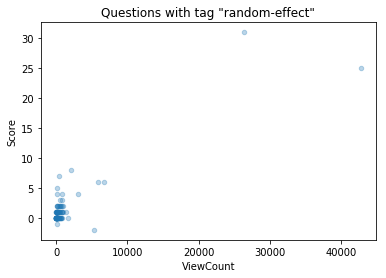

In [24]:
_ = view_score.plot.scatter("ViewCount", "Score", s=20, alpha=0.3, title='Questions with tag "random-effect"')

**Explanations**: The two outliers at ~25k and 40k views count prevents us to see if there is a correlation between the two variables.

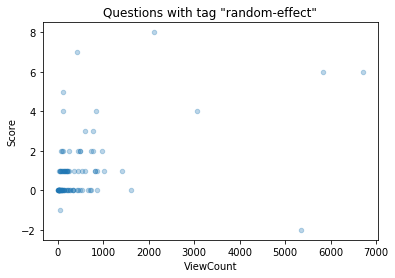

In [25]:
_ = view_score[view_score.ViewCount<10000]\
    .plot.scatter("ViewCount", "Score", s=20, alpha=0.3, title='Questions with tag "random-effect"')

**Explanations**: Even without the two outliers, we can say that the variables are not correlated. The cluster of points for the score 0-2 accounts for a large proportion of the samples and there is no clear linear relation in it. We already know that the Pearson coefficient will be meaningless with this dataset because of the outliers.

#### 2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

In [26]:
r, _ = sp.stats.pearsonr(view_score.ViewCount, view_score.Score)
print("Pearson correlation={:.3f} (with outliers)".format(r))

Pearson correlation=0.882 (with outliers)


In [27]:
view_score_1 = view_score[view_score.ViewCount < 10000]
r, pvalue = sp.stats.pearsonr(view_score_1.ViewCount, view_score_1.Score)
print("Pearson correlation={:.3f} (without points at ViewCount > 10000)".format(r, pvalue))

Pearson correlation=0.439 (without points at ViewCount > 10000)


**Explanations**: By removing only two outliers we have divided the Pearson correlation by two!
This confirm that the Pearson correlation is applicable only if there are no outliers. 

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


#### 1. Get the response time for the first answer of the questions with the tags python and java.

In [28]:
answers_df.printSchema()

root
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- Score: long (nullable = true)



In [29]:
# Get the first answer of each question
tmp = answers_df.groupBy("ParentId").agg(F.min('CreationDate').alias('CreationDate'))

# Join the answer to its question
tmp = tmp.join(
    questions_df.select(questions_df.Id, questions_df.CreationDate.alias("QuestionDate")), 
    on=[(questions_df.Id==answers_df.ParentId)]).drop("Id")

# Calculate the response time
rt = tmp.withColumn("ResponseTime", F.unix_timestamp(tmp.CreationDate)-F.unix_timestamp(tmp.QuestionDate))\
        .drop("QuestionDate")
    
rt.persist()
rt.printSchema()
rt.describe().show()

root
 |-- ParentId: long (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- ResponseTime: long (nullable = true)

+-------+--------------------+------------------+
|summary|            ParentId|      ResponseTime|
+-------+--------------------+------------------+
|  count|            13582820|          13582820|
|   mean|2.6039378621347997E7|1164881.1913124078|
| stddev|1.4789156113105278E7| 7481559.416447088|
|    min|                   6|        -184239128|
|    max|            52134299|         303565136|
+-------+--------------------+------------------+



In [30]:
print("Count of answers with negative ResponseTime =", rt.filter(rt.ResponseTime<=0).count())

# Keep rows that have a positive response time
rt = rt.filter(rt.ResponseTime>0)

Count of answers with negative ResponseTime = 36018


**Note:** we chose to remove the answers with an inconsistent ResponseTime that is less than or equals to 0. Apparently there is a problem with the timestamp in the dataset.

In [31]:
# Keep answer to question with the tags python or java
java_python_rt = rt .select(rt.ParentId, rt.ResponseTime)\
                    .join(q_tags, on=[(rt.ParentId==q_tags.Id)])\
                    .filter(q_tags.Tag.isin("python", "java"))\
                    .select("ParentId", "Tag", "ResponseTime")

In [32]:
java_python_rt.write.parquet("data/java_python_rt.parquet")

In [33]:
java_python_rt = spark.read.load("data/java_python_rt.parquet")
java_python_pd = java_python_rt.toPandas()

# Print the first five rows
java_python_pd.head(5)

ParentId     Tag  ResponseTime
0      2158    java           926
1     32586    java          3148
2     53027  python           256
3    150532  python           191
4    164105    java          2583

#### 2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.

In [34]:
# Convert seconds to hours
java_python_pd.ResponseTime = java_python_pd.ResponseTime.apply(lambda d: d/3600)

java_rt = java_python_pd[java_python_pd.Tag=="java"].ResponseTime.values
python_rt = java_python_pd[java_python_pd.Tag=="python"].ResponseTime.values

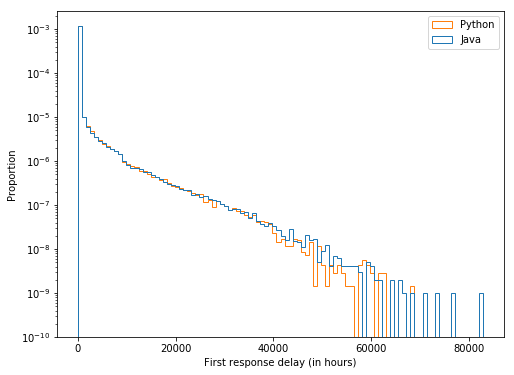

In [35]:
plt.figure(figsize=(8,6))
plt.hist([java_rt, python_rt], histtype="step", bins=100, log=True, density=True, label=["Java", "Python"])
plt.xlabel("First response delay (in hours)")
plt.ylabel("Proportion")
_ = plt.legend()

In [36]:
java_python_pd.groupby("Tag").describe()['ResponseTime']

count        mean          std       min       25%       50%  \
Tag                                                                        
java    1176818.0  277.465432  1981.406606  0.000278  0.110000  0.340000   
python   827848.0  273.254770  1919.007300  0.000278  0.118056  0.376944   

             75%           max  
Tag                             
java    2.670833  82926.862500  
python  2.661944  68460.423611

**Explanations**: We can observe that the distribution of the response time for the two languages are very similar. This is clear on the histogram and is confirmed with the very similar values for the mean, median and standard deviation. The standard deviation seems very large. Indeed (for java but same applies for python), the median is equal to 0.34 while the mean is equal to 277 hours. This shows that in most cases, answers are given very quickly (75% are given in less than 3 hours) but there are also clear outliers with response time being very large. 

#### 3. We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.

In [37]:
def bootstrap(data, number_of_samples, estimator=np.median, t=1.96):
    # take the samples and apply the function
    results = [estimator(data[np.random.randint(0, len(data), size=len(data))]) for _ in range(number_of_samples)]
    # compute the confidence interval
    std = np.std(results)
    mu = np.mean(results)
    CI = (mu-std*t, mu+std*t)
    return results, CI

In [38]:
number_of_samples = 1000
# we chose to bootstrap the median of the repsonse times because of the outliers
java_medians, java_ci = bootstrap(java_rt, number_of_samples, estimator=np.median, t=1.962)
python_medians, python_ci = bootstrap(python_rt, number_of_samples, estimator=np.median, t=1.962)

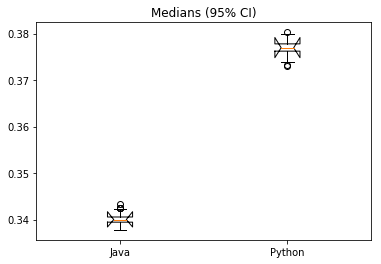

In [39]:
fig1, ax = plt.subplots()
ax.set_title('Medians (95% CI)')
_ = ax.boxplot([java_medians, python_medians], 
                labels=["Java", "Python"], 
                notch=True, conf_intervals=[java_ci, python_ci])

**Explanations**: 

We computed the CI bounds with this formula: $\textbf{CI}=[\mu_\bar{X}-t\cdot\sigma_\bar{X}, \ \ \mu_\bar{X}+t\cdot\sigma_\bar{X}]$, where $t=1.962$ given by the quantiles from the bootstrap distribution of the Student's t-test with 999 degrees of freedom for a 95% confidence interval

First, we are sure at 95% confidence that the medians of the response for the two tags are indeed different as the two intervals don't overlap. Second, we can see that Python has a longer response time than Java which contradicts the assumption.

***4. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.***

In [40]:
# Keep only the tags that appear more than 5000 times 
tags_5000 = tags_count.filter(tags_count.Count>5000)
qtag_5000 = tags_5000.join(q_tags, on="Tag", how="inner")

In [41]:
# spark.sql doesn't have a median function, so we created an udf one
def median(values_list):
    med = np.median(values_list)
    return float(med)
udf_median = F.udf(median, FloatType())

# compute a new DF with median and mean of reponse time for each tags (see schema in cell output)
tags_rt = rt.select(rt.ParentId, rt.ResponseTime)\
            .join(qtag_5000, on=[(rt.ParentId==qtag_5000.Id)])\
            .groupBy("Tag")\
                .agg(udf_median(F.collect_list(F.col('ResponseTime'))).alias("rt_median"),
                    F.mean(F.col('ResponseTime')).alias("rt_mean"))
tags_rt.printSchema()

root
 |-- Tag: string (nullable = true)
 |-- rt_median: float (nullable = true)
 |-- rt_mean: double (nullable = true)



In [42]:
# Take the 10 fastest reponse time by using the MEDIAN
tags_smallest_median = pd.DataFrame(tags_rt.select("Tag", "rt_median").sort(tags_rt.rt_median.asc()).head(10))
tags_smallest_median.columns = ["Tag", "Median of response time"]
tags_smallest_median.set_index("Tag", inplace=True)

# Take the 10 fastest reponse time by using the MEAN
tags_smallest_mean = pd.DataFrame(tags_rt.select("Tag", "rt_mean").sort(tags_rt.rt_mean.asc()).head(10))
tags_smallest_mean.columns = ["Tag", "Mean of response time"]
tags_smallest_mean.set_index("Tag", inplace=True)

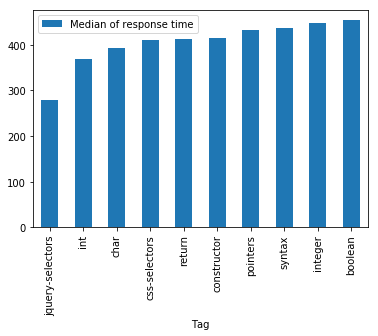

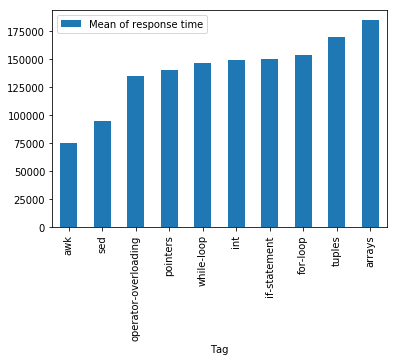

In [43]:
# and create the barplot
tags_smallest_median.plot.bar()
_ = tags_smallest_mean.plot.bar()

**Explanations**: We can see that the 10 tags that get the fastest responses are not the same if we take the median or the mean of the response times. This is due to the outliers that are present in this column and the fact that the median is more robust to outliers than the mean.

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [44]:
q_tags.printSchema()

root
 |-- Id: long (nullable = true)
 |-- Tag: string (nullable = true)



In [45]:
questions_df.printSchema()

root
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [46]:
pyspark_questions = q_tags.filter(q_tags.Tag=="pyspark")

In [47]:
pyspark_questions = pyspark_questions   .join(questions_df, on=[(pyspark_questions.Id==questions_df.Id)])\
                                        .select("CreationDate")

In [48]:
# split the year in two fields: year and month
py_month_year = pyspark_questions.rdd.map(lambda row:
    Row(year=row.CreationDate.year, month=row.CreationDate.month))

In [49]:
# compute the count of question for each months
py_month_year_df = py_month_year.toDF().toPandas()
py_month_year_df = py_month_year_df.groupby(["year", "month"]).size()

Text(0.5, 1.0, 'PySpark questions over time')

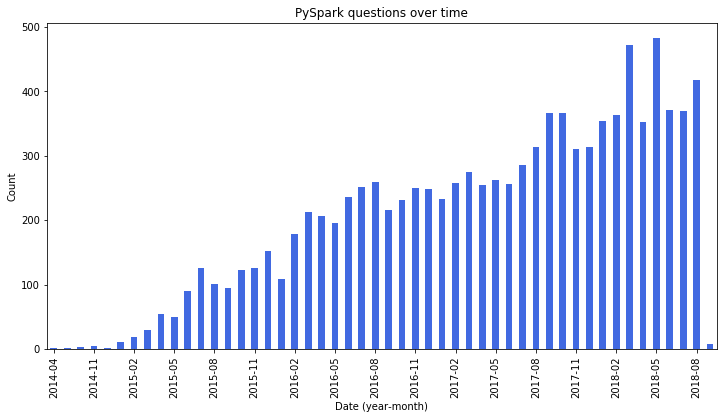

In [50]:
py_month_year_df.plot.bar(figsize=(12,6), color="royalblue")
# display a label every three months
ticks = py_month_year_df.index.values[0::3]
labels = [f"{t[0]}-{t[1]:02d}" for t in ticks]
plt.xticks(range(0, py_month_year_df.shape[0], 3), labels)
plt.xlabel("Date (year-month)")
plt.ylabel("Count")
plt.title("PySpark questions over time")

There is a clear rising popularity for pyspark on Stack overflow which starts almost when the first version of Spark was released ([Wikipedia page of Spark](https://fr.wikipedia.org/wiki/Apache_Spark)). There is also a clear, almost linear, relation between time and number of questions. The dataset has probably been collected at the start of September 2018 since the count of questions is very low for this month. 

Note: all the months are not represented between April and November 2014